# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


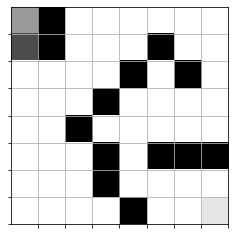

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [10]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.

    for epoch in range(n_epoch):
        print('\n')
        print('---------------')
        print('new epoch started\n')
        print('---------------')
        print('\n')

        #Randomly selecting a free cell to have the agent beign in. With an array having a length of 2
        agent_cell = np.random.randint(0, high=7, size=2)
        
        #resets the agent at the beginning of the maze
        qmaze.reset([0, 0])
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
                
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            inputs,targets = experience.get_data()
            history = model.fit(inputs, targets, epochs= 17, batch_size=25, verbose=0)
            loss = model.evaluate(inputs, targets)
            if episode [4] == "win":
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
                
            if episode [4] == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
                
        if win_rate > epsilon:
            print("win_rate is: ", win_rate)
            
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

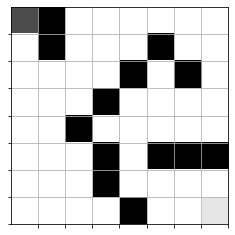

In [11]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [12]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)



---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
Epoch: 000/14999 | Loss: 0.0001 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 7.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 52us/step
Epoch: 001/14999 | Loss: 0.0006 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 11.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 54us/step
Epoch: 002/14999 | Loss: 0.0001 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 16.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 003/14999 | Loss: 0.0003 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 21.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 51us/step
Epoch: 004/14999 | Loss: 0.0003 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 26.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 57us/step
Epoch: 005/14999 | Loss: 0.0001 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 31.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 006/14999 | Loss: 0.0011 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 36.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 50us/step
Epoch: 007/14999 | Loss: 0.0011 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 40.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 008/14999 | Loss: 0.0010 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 45.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 009/14999 | Loss: 0.0003 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 49.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 010/14999 | Loss: 0.0012 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 54.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 52us/step
Epoch: 011/14999 | Loss: 0.0004 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 58.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
Epoch: 012/14999 | Loss: 0.0001 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 63.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 55us/step
Epoch: 013/14999 | Loss: 0.0008 | Episodes: 159 | Win count: 0 | Win rate: 0.000 | time: 68.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 014/14999 | Loss: 0.0008 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 72.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 54us/step
Epoch: 015/14999 | Loss: 0.0012 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 77.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
Epoch: 016/14999 | Loss: 0.0017 | Episodes: 62 | Win count: 1 | Win rate: 0.059 | time: 79.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.1111111111111111
Epoch: 017/14999 | Loss: 0.0012 | Episodes: 58 | Win count: 2 | Win rate: 0.111 | time: 80.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.15789473684210525
Epoch: 018/14999 | Loss: 0.0001 | Episodes: 67 | Win count: 3 | Win rate: 0.158 | time: 82.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.2
Epoch: 019/14999 | Loss: 0.0013 | Episodes: 63 | Win count: 4 | Win rate: 0.200 | time: 84.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.23809523809523808
Epoch: 020/14999 | Loss: 0.0018 | Episodes: 38 | Win count: 5 | Win rate: 0.238 | time: 86.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 56us/step
win_rate is:  0.2727272727272727
Epoch: 021/14999 | Loss: 0.0015 | Episodes: 103 | Win count: 6 | Win rate: 0.273 | time: 89.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.30434782608695654
Epoch: 022/14999 | Loss: 0.0016 | Episodes: 30 | Win count: 7 | Win rate: 0.304 | time: 90.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.3333333333333333
Epoch: 023/14999 | Loss: 0.0023 | Episodes: 40 | Win count: 8 | Win rate: 0.333 | time: 91.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.36
Epoch: 024/14999 | Loss: 0.0014 | Episodes: 55 | Win count: 9 | Win rate: 0.360 | time: 93.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.38461538461538464
Epoch: 025/14999 | Loss: 0.0005 | Episodes: 43 | Win count: 10 | Win rate: 0.385 | time: 94.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 56us/step
win_rate is:  0.4074074074074074
Epoch: 026/14999 | Loss: 0.0006 | Episodes: 115 | Win count: 11 | Win rate: 0.407 | time: 97.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.42857142857142855
Epoch: 027/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 12 | Win rate: 0.429 | time: 98.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.4482758620689655
Epoch: 028/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 13 | Win rate: 0.448 | time: 99.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.4666666666666667
Epoch: 029/14999 | Loss: 0.0012 | Episodes: 36 | Win count: 14 | Win rate: 0.467 | time: 100.6 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 51us/step
win_rate is:  0.4838709677419355
Epoch: 030/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 15 | Win rate: 0.484 | time: 101.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.5
Epoch: 031/14999 | Loss: 0.0003 | Episodes: 31 | Win count: 16 | Win rate: 0.500 | time: 102.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.5151515151515151
Epoch: 032/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 17 | Win rate: 0.515 | time: 103.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.5294117647058824
Epoch: 033/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 18 | Win rate: 0.529 | time: 104.5 seconds


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 57us/step
win_rate is:  0.5428571428571428
Epoch: 034/14999 | Loss: 0.0007 | Episodes: 35 | Win count: 19 | Win rate: 0.543 | time: 105.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.5555555555555556
Epoch: 035/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 20 | Win rate: 0.556 | time: 106.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.5675675675675675
Epoch: 036/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 21 | Win rate: 0.568 | time: 107.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.5789473684210527
Epoch: 037/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 22 | Win rate: 0.579 | time: 108.1 seconds


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 54us/step
win_rate is:  0.6
Epoch: 039/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 24 | Win rate: 0.600 | time: 109.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.6097560975609756
Epoch: 040/14999 | Loss: 0.0011 | Episodes: 67 | Win count: 25 | Win rate: 0.610 | time: 111.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.6190476190476191
Epoch: 041/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 26 | Win rate: 0.619 | time: 112.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.6046511627906976
Epoch: 042/14999 | Loss: 0.0009 | Episodes: 141 | Win count: 26 | Win rate: 0.605 | time: 116.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.6136363636363636
Epoch: 043/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 27 | Win rate: 0.614 | time: 118.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.6
Epoch: 044/14999 | Loss: 0.0006 | Episodes: 142 | Win count: 27 | Win rate: 0.600 | time: 122.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.6086956521739131
Epoch: 045/14999 | Loss: 0.0012 | Episodes: 65 | Win count: 28 | Win rate: 0.609 | time: 124.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 51us/step
win_rate is:  0.5957446808510638
Epoch: 046/14999 | Loss: 0.0013 | Episodes: 139 | Win count: 28 | Win rate: 0.596 | time: 128.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.6041666666666666
Epoch: 047/14999 | Loss: 0.0009 | Episodes: 92 | Win count: 29 | Win rate: 0.604 | time: 130.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.6122448979591837
Epoch: 048/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 30 | Win rate: 0.612 | time: 131.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.62
Epoch: 049/14999 | Loss: 0.0001 | Episodes: 53 | Win count: 31 | Win rate: 0.620 | time: 133.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.6274509803921569
Epoch: 050/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 32 | Win rate: 0.627 | time: 133.8 seconds


---------------
new epoch started

---------------


10/10 [===========================

10/10 [==============================] - 0s 56us/step
win_rate is:  0.6346153846153846
Epoch: 051/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 33 | Win rate: 0.635 | time: 134.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.6415094339622641
Epoch: 052/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 34 | Win rate: 0.642 | time: 135.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.6481481481481481
Epoch: 053/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 35 | Win rate: 0.648 | time: 136.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.6545454545454545
Epoch: 054/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 36 | Win rate: 0.655 | time: 137.0 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 56us/step
win_rate is:  0.6666666666666666
Epoch: 056/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 38 | Win rate: 0.667 | time: 138.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.6724137931034483
Epoch: 057/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 39 | Win rate: 0.672 | time: 139.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.6779661016949152
Epoch: 058/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 40 | Win rate: 0.678 | time: 140.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.6833333333333333
Epoch: 059/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 41 | Win rate: 0.683 | time: 140.8 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 53us/step
win_rate is:  0.6935483870967742
Epoch: 061/14999 | Loss: 0.0008 | Episodes: 37 | Win count: 43 | Win rate: 0.694 | time: 142.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.6984126984126984
Epoch: 062/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 44 | Win rate: 0.698 | time: 143.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.703125
Epoch: 063/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 45 | Win rate: 0.703 | time: 144.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7076923076923077
Epoch: 064/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 46 | Win rate: 0.708 | time: 144.8 seconds


---------------
new epoch started

---------------


10/10 [=======================

win_rate is:  0.7121212121212122
Epoch: 065/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 47 | Win rate: 0.712 | time: 145.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7164179104477612
Epoch: 066/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 48 | Win rate: 0.716 | time: 146.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7205882352941176
Epoch: 067/14999 | Loss: 0.0008 | Episodes: 35 | Win count: 49 | Win rate: 0.721 | time: 147.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7246376811594203
Epoch: 068/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 50 | Win rate: 0.725 | time: 147.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7285

10/10 [==============================] - 0s 52us/step
win_rate is:  0.7361111111111112
Epoch: 071/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 53 | Win rate: 0.736 | time: 150.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.7397260273972602
Epoch: 072/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 54 | Win rate: 0.740 | time: 151.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7432432432432432
Epoch: 073/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 55 | Win rate: 0.743 | time: 151.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7466666666666667
Epoch: 074/14999 | Loss: 0.0001 | Episodes: 70 | Win count: 56 | Win rate: 0.747 | time: 153.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.75
Epoch: 075/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 57 | Win rate: 0.750 | time: 154.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.7532467532467533
Epoch: 076/14999 | Loss: 0.0009 | Episodes: 37 | Win count: 58 | Win rate: 0.753 | time: 155.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7564102564102564
Epoch: 077/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 59 | Win rate: 0.756 | time: 156.5 seconds


---------------
new epoch started

---------------


10/10 [==========================

10/10 [==============================] - 0s 106us/step
win_rate is:  0.7468354430379747
Epoch: 078/14999 | Loss: 0.0007 | Episodes: 140 | Win count: 59 | Win rate: 0.747 | time: 160.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 49us/step
win_rate is:  0.75
Epoch: 079/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 60 | Win rate: 0.750 | time: 161.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 107us/step
win_rate is:  0.7530864197530864
Epoch: 080/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 61 | Win rate: 0.753 | time: 162.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7560975609756098
Epoch: 081/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 62 | Win rate: 0.756 | time: 163.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7469879518072289
Epoch: 082/14999 | Loss: 0.0001 | Episodes: 142 | Win count: 62 | Win rate: 0.747 | time: 167.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.75
Epoch: 083/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 63 | Win rate: 0.750 | time: 168.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7411764705882353
Epoch: 084/14999 | Loss: 0.0001 | Episodes: 139 | Win count: 63 | Win rate: 0.741 | time: 172.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7441860465116279
Epoch: 085/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 64 | Win rate: 0.744 | time: 173.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7471264367816092
Epoch: 086/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 65 | Win rate: 0.747 | time: 173.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7386363636363636
Epoch: 087/14999 | Loss: 0.0003 | Episodes: 138 | Win count: 65 | Win rate: 0.739 | time: 177.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.7415730337078652
Epoch: 088/14999 | Loss: 0.0008 | Episodes: 41 | Win count: 66 | Win rate: 0.742 | time: 179.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7444444444444445
Epoch: 089/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 67 | Win rate: 0.744 | time: 179.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 50us/step
win_rate is:  0.7362637362637363
Epoch: 090/14999 | Loss: 0.0001 | Episodes: 142 | Win count: 67 | Win rate: 0.736 | time: 184.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7282608695652174
Epoch: 091/14999 | Loss: 0.0008 | Episodes: 143 | Win count: 67 | Win rate: 0.728 | time: 188.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7204301075268817
Epoch: 092/14999 | Loss: 0.0002 | Episodes: 143 | Win count: 67 | Win rate: 0.720 | time: 192.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.723404255319149
Epoch: 093/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 68 | Win rate: 0.723 | time: 193.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7263157894736842
Epoch: 094/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 69 | Win rate: 0.726 | time: 194.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.7291666666666666
Epoch: 095/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 70 | Win rate: 0.729 | time: 194.9 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.7346938775510204
Epoch: 097/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 72 | Win rate: 0.735 | time: 196.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7373737373737373
Epoch: 098/14999 | Loss: 0.0007 | Episodes: 61 | Win count: 73 | Win rate: 0.737 | time: 198.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.74
Epoch: 099/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 74 | Win rate: 0.740 | time: 199.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7425742574257426
Epoch: 100/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 75 | Win rate: 0.743 | time: 200.0 seconds


---------------
new epoch started

---------------


10/10 [===========================

10/10 [==============================] - 0s 55us/step
win_rate is:  0.7450980392156863
Epoch: 101/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 76 | Win rate: 0.745 | time: 200.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.7475728155339806
Epoch: 102/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 77 | Win rate: 0.748 | time: 201.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.75
Epoch: 103/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 78 | Win rate: 0.750 | time: 202.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7523809523809524
Epoch: 104/14999 | Loss: 0.0004 | Episodes: 27 | Win count: 79 | Win rate: 0.752 | time: 203.0 seconds


---------------
new epoch started

---------------


10/10 [===========================

10/10 [==============================] - 0s 55us/step
win_rate is:  0.7570093457943925
Epoch: 106/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 81 | Win rate: 0.757 | time: 204.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7592592592592593
Epoch: 107/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 82 | Win rate: 0.759 | time: 205.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7614678899082569
Epoch: 108/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 83 | Win rate: 0.761 | time: 206.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7636363636363637
Epoch: 109/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 84 | Win rate: 0.764 | time: 206.9 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 109us/step
win_rate is:  0.7678571428571429
Epoch: 111/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 86 | Win rate: 0.768 | time: 208.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.7699115044247787
Epoch: 112/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 87 | Win rate: 0.770 | time: 209.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.7719298245614035
Epoch: 113/14999 | Loss: 0.0016 | Episodes: 28 | Win count: 88 | Win rate: 0.772 | time: 210.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 49us/step
win_rate is:  0.7739130434782608
Epoch: 114/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 89 | Win rate: 0.774 | time: 210.8 seconds


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.7777777777777778
Epoch: 116/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 91 | Win rate: 0.778 | time: 212.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7796610169491526
Epoch: 117/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 92 | Win rate: 0.780 | time: 213.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7815126050420168
Epoch: 118/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 93 | Win rate: 0.782 | time: 213.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7833333333333333
Epoch: 119/14999 | Loss: 0.0021 | Episodes: 30 | Win count: 94 | Win rate: 0.783 | time: 214.7 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 54us/step
win_rate is:  0.7851239669421488
Epoch: 120/14999 | Loss: 0.0004 | Episodes: 145 | Win count: 95 | Win rate: 0.785 | time: 219.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.7868852459016393
Epoch: 121/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 96 | Win rate: 0.787 | time: 220.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.7804878048780488
Epoch: 122/14999 | Loss: 0.0003 | Episodes: 140 | Win count: 96 | Win rate: 0.780 | time: 224.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.782258064516129
Epoch: 123/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 97 | Win rate: 0.782 | time: 224.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.784
Epoch: 124/14999 | Loss: 0.0016 | Episodes: 27 | Win count: 98 | Win rate: 0.784 | time: 225.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7777777777777778
Epoch: 125/14999 | Loss: 0.0001 | Episodes: 138 | Win count: 98 | Win rate: 0.778 | time: 229.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.7795275590551181
Epoch: 126/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 99 | Win rate: 0.780 | time: 230.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.78125
Epoch: 127/14999 | Loss: 0.0005 | Episodes: 31 | Win count: 100 | Win rate: 0.781 | time: 231.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7829457364341085
Epoch: 128/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 101 | Win rate: 0.783 | time: 232.4 seconds


---------------
new epoch started

---------------


10/10 [=====================

10/10 [==============================] - 0s 52us/step
win_rate is:  0.7769230769230769
Epoch: 129/14999 | Loss: 0.0012 | Episodes: 141 | Win count: 101 | Win rate: 0.777 | time: 236.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7786259541984732
Epoch: 130/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 102 | Win rate: 0.779 | time: 237.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.7803030303030303
Epoch: 131/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 103 | Win rate: 0.780 | time: 238.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.7819548872180451
Epoch: 132/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 104 | Win rate: 0.782 | time: 239.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.7835820895522388
Epoch: 133/14999 | Loss: 0.0019 | Episodes: 31 | Win count: 105 | Win rate: 0.784 | time: 239.9 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 53us/step
win_rate is:  0.7777777777777778
Epoch: 134/14999 | Loss: 0.0001 | Episodes: 142 | Win count: 105 | Win rate: 0.778 | time: 243.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.7794117647058824
Epoch: 135/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 106 | Win rate: 0.779 | time: 244.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 51us/step
win_rate is:  0.781021897810219
Epoch: 136/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 107 | Win rate: 0.781 | time: 245.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.782608695652174
Epoch: 137/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 108 | Win rate: 0.783 | time: 246.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7841726618705036
Epoch: 138/14999 | Loss: 0.0018 | Episodes: 37 | Win count: 109 | Win rate: 0.784 | time: 247.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.7857142857142857
Epoch: 139/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 110 | Win rate: 0.786 | time: 248.3 seconds


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 57us/step
win_rate is:  0.7887323943661971
Epoch: 141/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 112 | Win rate: 0.789 | time: 249.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7902097902097902
Epoch: 142/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 113 | Win rate: 0.790 | time: 250.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.7916666666666666
Epoch: 143/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 114 | Win rate: 0.792 | time: 251.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7931034482758621
Epoch: 144/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 115 | Win rate: 0.793 | time: 252.3 seconds


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.7959183673469388
Epoch: 146/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 117 | Win rate: 0.796 | time: 253.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.7972972972972973
Epoch: 147/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 118 | Win rate: 0.797 | time: 254.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.7986577181208053
Epoch: 148/14999 | Loss: 0.0005 | Episodes: 55 | Win count: 119 | Win rate: 0.799 | time: 256.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8
Epoch: 149/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 120 | Win rate: 0.800 | time: 257.3 seconds


---------------
new epoch started



---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8013245033112583
Epoch: 150/14999 | Loss: 0.0008 | Episodes: 33 | Win count: 121 | Win rate: 0.801 | time: 258.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8026315789473685
Epoch: 151/14999 | Loss: 0.0004 | Episodes: 27 | Win count: 122 | Win rate: 0.803 | time: 259.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.803921568627451
Epoch: 152/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 123 | Win rate: 0.804 | time: 260.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8051948051948052
Epoch: 153/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 124 | Win rate: 0.805 | time: 260.9 seconds


---------------
new epoch started

---------------




10/10 [==============================] - 0s 55us/step
win_rate is:  0.8064516129032258
Epoch: 154/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 125 | Win rate: 0.806 | time: 261.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8076923076923077
Epoch: 155/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 126 | Win rate: 0.808 | time: 262.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8089171974522293
Epoch: 156/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 127 | Win rate: 0.809 | time: 263.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.810126582278481
Epoch: 157/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 128 | Win rate: 0.810 | time: 264.4 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 55us/step
win_rate is:  0.80625
Epoch: 159/14999 | Loss: 0.0002 | Episodes: 140 | Win count: 129 | Win rate: 0.806 | time: 269.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8012422360248447
Epoch: 160/14999 | Loss: 0.0001 | Episodes: 141 | Win count: 129 | Win rate: 0.801 | time: 273.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8024691358024691
Epoch: 161/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 130 | Win rate: 0.802 | time: 274.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.803680981595092
Epoch: 162/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 131 | Win rate: 0.804 | time: 274.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8048780487804879
Epoch: 163/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 132 | Win rate: 0.805 | time: 275.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.806060606060606
Epoch: 164/14999 | Loss: 0.0008 | Episodes: 40 | Win count: 133 | Win rate: 0.806 | time: 277.0 seconds


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 54us/step
win_rate is:  0.8072289156626506
Epoch: 165/14999 | Loss: 0.0004 | Episodes: 31 | Win count: 134 | Win rate: 0.807 | time: 278.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8083832335329342
Epoch: 166/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 135 | Win rate: 0.808 | time: 278.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8095238095238095
Epoch: 167/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 136 | Win rate: 0.810 | time: 279.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.8106508875739645
Epoch: 168/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 137 | Win rate: 0.811 | time: 280.5 seconds


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.8117647058823529
Epoch: 169/14999 | Loss: 0.0004 | Episodes: 67 | Win count: 138 | Win rate: 0.812 | time: 282.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8128654970760234
Epoch: 170/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 139 | Win rate: 0.813 | time: 283.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.813953488372093
Epoch: 171/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 140 | Win rate: 0.814 | time: 284.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.815028901734104
Epoch: 172/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 141 | Win rate: 0.815 | time: 285.3 seconds


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8171428571428572
Epoch: 174/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 143 | Win rate: 0.817 | time: 286.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8181818181818182
Epoch: 175/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 144 | Win rate: 0.818 | time: 287.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8192090395480226
Epoch: 176/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 145 | Win rate: 0.819 | time: 288.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8202247191011236
Epoch: 177/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 146 | Win rate: 0.820 | time: 289.2 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.8222222222222222
Epoch: 179/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 148 | Win rate: 0.822 | time: 291.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8232044198895028
Epoch: 180/14999 | Loss: 0.0011 | Episodes: 32 | Win count: 149 | Win rate: 0.823 | time: 292.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8241758241758241
Epoch: 181/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 150 | Win rate: 0.824 | time: 292.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.825136612021858
Epoch: 182/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 151 | Win rate: 0.825 | time: 293.8 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8260869565217391
Epoch: 183/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 152 | Win rate: 0.826 | time: 294.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.827027027027027
Epoch: 184/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 153 | Win rate: 0.827 | time: 295.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8279569892473119
Epoch: 185/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 154 | Win rate: 0.828 | time: 296.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8288770053475936
Epoch: 186/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 155 | Win rate: 0.829 | time: 297.0 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 109us/step
win_rate is:  0.8306878306878307
Epoch: 188/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 157 | Win rate: 0.831 | time: 298.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8315789473684211
Epoch: 189/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 158 | Win rate: 0.832 | time: 299.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8324607329842932
Epoch: 190/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 159 | Win rate: 0.832 | time: 300.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8333333333333334
Epoch: 191/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 160 | Win rate: 0.833 | time: 301.0 seconds


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.8350515463917526
Epoch: 193/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 162 | Win rate: 0.835 | time: 302.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8358974358974359
Epoch: 194/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 163 | Win rate: 0.836 | time: 303.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.8367346938775511
Epoch: 195/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 164 | Win rate: 0.837 | time: 305.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8375634517766497
Epoch: 196/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 165 | Win rate: 0.838 | time: 306.2 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.8383838383838383
Epoch: 197/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 166 | Win rate: 0.838 | time: 307.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8391959798994975
Epoch: 198/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 167 | Win rate: 0.839 | time: 308.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.84
Epoch: 199/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 168 | Win rate: 0.840 | time: 309.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8407960199004975
Epoch: 200/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 169 | Win rate: 0.841 | time: 310.8 seconds


---------------
new epoch started

---------------


10/10 [========================

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8423645320197044
Epoch: 202/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 171 | Win rate: 0.842 | time: 313.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8431372549019608
Epoch: 203/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 172 | Win rate: 0.843 | time: 314.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8439024390243902
Epoch: 204/14999 | Loss: 0.0004 | Episodes: 47 | Win count: 173 | Win rate: 0.844 | time: 315.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8446601941747572
Epoch: 205/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 174 | Win rate: 0.845 | time: 316.8 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 51us/step
win_rate is:  0.8454106280193237
Epoch: 206/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 175 | Win rate: 0.845 | time: 317.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8461538461538461
Epoch: 207/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 176 | Win rate: 0.846 | time: 318.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.84688995215311
Epoch: 208/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 177 | Win rate: 0.847 | time: 319.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8476190476190476
Epoch: 209/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 178 | Win rate: 0.848 | time: 320.9 seconds


---------------
new epoch started

---------------


10/10 [===========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8490566037735849
Epoch: 211/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 180 | Win rate: 0.849 | time: 322.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8497652582159625
Epoch: 212/14999 | Loss: 0.0010 | Episodes: 85 | Win count: 181 | Win rate: 0.850 | time: 325.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8504672897196262
Epoch: 213/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 182 | Win rate: 0.850 | time: 326.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8511627906976744
Epoch: 214/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 183 | Win rate: 0.851 | time: 328.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8518518518518519
Epoch: 215/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 184 | Win rate: 0.852 | time: 329.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8525345622119815
Epoch: 216/14999 | Loss: 0.0016 | Episodes: 30 | Win count: 185 | Win rate: 0.853 | time: 330.6 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 53us/step
win_rate is:  0.8538812785388128
Epoch: 218/14999 | Loss: 0.0003 | Episodes: 48 | Win count: 187 | Win rate: 0.854 | time: 333.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8545454545454545
Epoch: 219/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 188 | Win rate: 0.855 | time: 334.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.8552036199095022
Epoch: 220/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 189 | Win rate: 0.855 | time: 335.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8558558558558559
Epoch: 221/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 190 | Win rate: 0.856 | time: 336.8 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8565022421524664
Epoch: 222/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 191 | Win rate: 0.857 | time: 337.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8571428571428571
Epoch: 223/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 192 | Win rate: 0.857 | time: 338.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8577777777777778
Epoch: 224/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 193 | Win rate: 0.858 | time: 339.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8584070796460177
Epoch: 225/14999 | Loss: 0.0006 | Episodes: 36 | Win count: 194 | Win rate: 0.858 | time: 341.1 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8596491228070176
Epoch: 227/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 196 | Win rate: 0.860 | time: 343.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8602620087336245
Epoch: 228/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 197 | Win rate: 0.860 | time: 344.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8608695652173913
Epoch: 229/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 198 | Win rate: 0.861 | time: 345.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8614718614718615
Epoch: 230/14999 | Loss: 0.0004 | Episodes: 52 | Win count: 199 | Win rate: 0.861 | time: 347.1 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8620689655172413
Epoch: 231/14999 | Loss: 0.0013 | Episodes: 34 | Win count: 200 | Win rate: 0.862 | time: 348.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8626609442060086
Epoch: 232/14999 | Loss: 0.0008 | Episodes: 46 | Win count: 201 | Win rate: 0.863 | time: 350.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8632478632478633
Epoch: 233/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 202 | Win rate: 0.863 | time: 351.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8638297872340426
Epoch: 234/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 203 | Win rate: 0.864 | time: 352.1 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.864406779661017
Epoch: 235/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 204 | Win rate: 0.864 | time: 353.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8649789029535865
Epoch: 236/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 205 | Win rate: 0.865 | time: 353.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.865546218487395
Epoch: 237/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 206 | Win rate: 0.866 | time: 354.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8661087866108786
Epoch: 238/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 207 | Win rate: 0.866 | time: 355.8 seconds


---------------
new epoch started

---------------


10/10 [===========

win_rate is:  0.8666666666666667
Epoch: 239/14999 | Loss: 0.0022 | Episodes: 30 | Win count: 208 | Win rate: 0.867 | time: 356.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8672199170124482
Epoch: 240/14999 | Loss: 0.0014 | Episodes: 34 | Win count: 209 | Win rate: 0.867 | time: 358.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8677685950413223
Epoch: 241/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 210 | Win rate: 0.868 | time: 359.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8683127572016461
Epoch: 242/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 211 | Win rate: 0.868 | time: 360.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.

10/10 [==============================] - 0s 53us/step
win_rate is:  0.8693877551020408
Epoch: 244/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 213 | Win rate: 0.869 | time: 362.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8699186991869918
Epoch: 245/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 214 | Win rate: 0.870 | time: 363.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8704453441295547
Epoch: 246/14999 | Loss: 0.0010 | Episodes: 39 | Win count: 215 | Win rate: 0.870 | time: 364.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8709677419354839
Epoch: 247/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 216 | Win rate: 0.871 | time: 365.7 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8714859437751004
Epoch: 248/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 217 | Win rate: 0.871 | time: 366.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.872
Epoch: 249/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 218 | Win rate: 0.872 | time: 367.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8725099601593626
Epoch: 250/14999 | Loss: 0.0005 | Episodes: 29 | Win count: 219 | Win rate: 0.873 | time: 368.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.873015873015873
Epoch: 251/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 220 | Win rate: 0.873 | time: 369.8 seconds


---------------
new epoch started

---------------


10/10 [========================

10/10 [==============================] - 0s 53us/step
win_rate is:  0.8740157480314961
Epoch: 253/14999 | Loss: 0.0016 | Episodes: 40 | Win count: 222 | Win rate: 0.874 | time: 371.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8745098039215686
Epoch: 254/14999 | Loss: 0.0009 | Episodes: 29 | Win count: 223 | Win rate: 0.875 | time: 372.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.875
Epoch: 255/14999 | Loss: 0.0009 | Episodes: 41 | Win count: 224 | Win rate: 0.875 | time: 374.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8754863813229572
Epoch: 256/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 225 | Win rate: 0.875 | time: 375.0 seconds


---------------
new epoch started

---------------


10/10 [======================

10/10 [==============================] - 0s 50us/step
win_rate is:  0.875968992248062
Epoch: 257/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 226 | Win rate: 0.876 | time: 375.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8764478764478765
Epoch: 258/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 227 | Win rate: 0.876 | time: 376.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.8769230769230769
Epoch: 259/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 228 | Win rate: 0.877 | time: 377.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8773946360153256
Epoch: 260/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 229 | Win rate: 0.877 | time: 379.0 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8783269961977186
Epoch: 262/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 231 | Win rate: 0.878 | time: 381.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.8787878787878788
Epoch: 263/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 232 | Win rate: 0.879 | time: 382.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.879245283018868
Epoch: 264/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 233 | Win rate: 0.879 | time: 383.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8796992481203008
Epoch: 265/14999 | Loss: 0.0009 | Episodes: 48 | Win count: 234 | Win rate: 0.880 | time: 385.0 seconds


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8801498127340824
Epoch: 266/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 235 | Win rate: 0.880 | time: 385.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8805970149253731
Epoch: 267/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 236 | Win rate: 0.881 | time: 386.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8810408921933085
Epoch: 268/14999 | Loss: 0.0001 | Episodes: 55 | Win count: 237 | Win rate: 0.881 | time: 388.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8814814814814815
Epoch: 269/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 238 | Win rate: 0.881 | time: 389.4 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 51us/step
win_rate is:  0.8819188191881919
Epoch: 270/14999 | Loss: 0.0012 | Episodes: 27 | Win count: 239 | Win rate: 0.882 | time: 390.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8823529411764706
Epoch: 271/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 240 | Win rate: 0.882 | time: 391.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8827838827838828
Epoch: 272/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 241 | Win rate: 0.883 | time: 392.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8832116788321168
Epoch: 273/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 242 | Win rate: 0.883 | time: 393.7 seconds


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8836363636363637
Epoch: 274/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 243 | Win rate: 0.884 | time: 394.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8840579710144928
Epoch: 275/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 244 | Win rate: 0.884 | time: 395.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.8844765342960289
Epoch: 276/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 245 | Win rate: 0.884 | time: 396.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8848920863309353
Epoch: 277/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 246 | Win rate: 0.885 | time: 397.8 seconds


---------------
new epoch started

---------------


10/10 [=========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8857142857142857
Epoch: 279/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 248 | Win rate: 0.886 | time: 6.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8861209964412812
Epoch: 280/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 249 | Win rate: 0.886 | time: 6.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8865248226950354
Epoch: 281/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 250 | Win rate: 0.887 | time: 6.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8869257950530035
Epoch: 282/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 251 | Win rate: 0.887 | time: 6.72 minutes


---------------
ne

10/10 [==============================] - 0s 56us/step
win_rate is:  0.8873239436619719
Epoch: 283/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 252 | Win rate: 0.887 | time: 6.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.887719298245614
Epoch: 284/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 253 | Win rate: 0.888 | time: 6.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8881118881118881
Epoch: 285/14999 | Loss: 0.0001 | Episodes: 127 | Win count: 254 | Win rate: 0.888 | time: 6.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8885017421602788
Epoch: 286/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 255 | Win rate: 0.889 | time: 6.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8888888888888888
Epoch: 287/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 256 | Win rate: 0.889 | time: 6.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.889273356401384
Epoch: 288/14999 | Loss: 0.0010 | Episodes: 52 | Win count: 257 | Win rate: 0.889 | time: 6.89 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 52us/step


win_rate is:  0.8896551724137931
Epoch: 289/14999 | Loss: 0.0005 | Episodes: 159 | Win count: 258 | Win rate: 0.890 | time: 6.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.8900343642611683
Epoch: 290/14999 | Loss: 0.0016 | Episodes: 30 | Win count: 259 | Win rate: 0.890 | time: 6.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8904109589041096
Epoch: 291/14999 | Loss: 0.0001 | Episodes: 37 | Win count: 260 | Win rate: 0.890 | time: 7.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8907849829351536
Epoch: 292/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 261 | Win rate: 0.891 | time: 7.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.891

10/10 [==============================] - 0s 53us/step
win_rate is:  0.8915254237288136
Epoch: 294/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 263 | Win rate: 0.892 | time: 7.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.8918918918918919
Epoch: 295/14999 | Loss: 0.0003 | Episodes: 51 | Win count: 264 | Win rate: 0.892 | time: 7.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8922558922558923
Epoch: 296/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 265 | Win rate: 0.892 | time: 7.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8926174496644296
Epoch: 297/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 266 | Win rate: 0.893 | time: 7.13 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8929765886287625
Epoch: 298/14999 | Loss: 0.0009 | Episodes: 49 | Win count: 267 | Win rate: 0.893 | time: 7.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8933333333333333
Epoch: 299/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 268 | Win rate: 0.893 | time: 7.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.893687707641196
Epoch: 300/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 269 | Win rate: 0.894 | time: 7.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8940397350993378
Epoch: 301/14999 | Loss: 0.0015 | Episodes: 30 | Win count: 270 | Win rate: 0.894 | time: 7.22 minutes


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8943894389438944
Epoch: 302/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 271 | Win rate: 0.894 | time: 7.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8947368421052632
Epoch: 303/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 272 | Win rate: 0.895 | time: 7.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8950819672131147
Epoch: 304/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 273 | Win rate: 0.895 | time: 7.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8954248366013072
Epoch: 305/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 274 | Win rate: 0.895 | time: 7.29 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8961038961038961
Epoch: 307/14999 | Loss: 0.0010 | Episodes: 35 | Win count: 276 | Win rate: 0.896 | time: 7.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.8964401294498382
Epoch: 308/14999 | Loss: 0.0007 | Episodes: 44 | Win count: 277 | Win rate: 0.896 | time: 7.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.896774193548387
Epoch: 309/14999 | Loss: 0.0011 | Episodes: 50 | Win count: 278 | Win rate: 0.897 | time: 7.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8971061093247589
Epoch: 310/14999 | Loss: 0.0011 | Episodes: 52 | Win count: 279 | Win rate: 0.897 | time: 7.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.8974358974358975
Epoch: 311/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 280 | Win rate: 0.897 | time: 7.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.8977635782747604
Epoch: 312/14999 | Loss: 0.0010 | Episodes: 71 | Win count: 281 | Win rate: 0.898 | time: 7.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8980891719745223
Epoch: 313/14999 | Loss: 0.0014 | Episodes: 24 | Win count: 282 | Win rate: 0.898 | time: 7.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.8984126984126984
Epoch: 314/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 283 | Win rate: 0.898 | time: 7.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8987341772151899
Epoch: 315/14999 | Loss: 0.0014 | Episodes: 40 | Win count: 284 | Win rate: 0.899 | time: 7.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.8990536277602523
Epoch: 316/14999 | Loss: 0.0006 | Episodes: 57 | Win count: 285 | Win rate: 0.899 | time: 7.54 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 50us/step
win_rate is:  0.89937106918239
Epoch: 317/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 286 | Win rate: 0.899 | time: 7.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.8996865203761756
Epoch: 318/14999 | Loss: 0.0013 | Episodes: 42 | Win count: 287 | Win rate: 0.900 | time: 7.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9
Epoch: 319/14999 | Loss: 0.0003 | Episodes: 39 | Win count: 288 | Win rate: 0.900 | time: 7.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9003115264797508
Epoch: 320/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 289 | Win rate: 0.900 | time: 7.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9006211180124224
Epoch: 321/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 290 | Win rate: 0.901 | time: 7.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9009287925696594
Epoch: 322/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 291 | Win rate: 0.901 | time: 7.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9012345679012346
Epoch: 323/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 292 | Win rate: 0.901 | time: 7.67 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.901840490797546
Epoch: 325/14999 | Loss: 0.0006 | Episodes: 40 | Win count: 294 | Win rate: 0.902 | time: 7.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9021406727828746
Epoch: 326/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 295 | Win rate: 0.902 | time: 7.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9024390243902439
Epoch: 327/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 296 | Win rate: 0.902 | time: 7.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9027355623100304
Epoch: 328/14999 | Loss: 0.0010 | Episodes: 27 | Win count: 297 | Win rate: 0.903 | time: 7.76 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9030303030303031
Epoch: 329/14999 | Loss: 0.0005 | Episodes: 39 | Win count: 298 | Win rate: 0.903 | time: 7.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9033232628398792
Epoch: 330/14999 | Loss: 0.0003 | Episodes: 37 | Win count: 299 | Win rate: 0.903 | time: 7.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9036144578313253
Epoch: 331/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 300 | Win rate: 0.904 | time: 7.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9039039039039038
Epoch: 332/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 301 | Win rate: 0.904 | time: 7.85 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 51us/step
win_rate is:  0.9041916167664671
Epoch: 333/14999 | Loss: 0.0003 | Episodes: 50 | Win count: 302 | Win rate: 0.904 | time: 7.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9044776119402985
Epoch: 334/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 303 | Win rate: 0.904 | time: 7.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9047619047619048
Epoch: 335/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 304 | Win rate: 0.905 | time: 7.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9050445103857567
Epoch: 336/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 305 | Win rate: 0.905 | time: 7.94 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9053254437869822
Epoch: 337/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 306 | Win rate: 0.905 | time: 7.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9056047197640118
Epoch: 338/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 307 | Win rate: 0.906 | time: 7.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.9058823529411765
Epoch: 339/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 308 | Win rate: 0.906 | time: 8.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.906158357771261
Epoch: 340/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 309 | Win rate: 0.906 | time: 8.04 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 111us/step
win_rate is:  0.9064327485380117
Epoch: 341/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 310 | Win rate: 0.906 | time: 8.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9067055393586005
Epoch: 342/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 311 | Win rate: 0.907 | time: 8.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 173us/step
win_rate is:  0.9069767441860465
Epoch: 343/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 312 | Win rate: 0.907 | time: 8.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9072463768115943
Epoch: 344/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 313 | Win rate: 0.907 | time: 8.20 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9075144508670521
Epoch: 345/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 314 | Win rate: 0.908 | time: 8.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9077809798270894
Epoch: 346/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 315 | Win rate: 0.908 | time: 8.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9080459770114943
Epoch: 347/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 316 | Win rate: 0.908 | time: 8.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9083094555873925
Epoch: 348/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 317 | Win rate: 0.908 | time: 8.34 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 108us/step
win_rate is:  0.9085714285714286
Epoch: 349/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 318 | Win rate: 0.909 | time: 8.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.9088319088319088
Epoch: 350/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 319 | Win rate: 0.909 | time: 8.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9090909090909091
Epoch: 351/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 320 | Win rate: 0.909 | time: 8.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9093484419263456
Epoch: 352/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 321 | Win rate: 0.909 | time: 8.49 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 167us/step
win_rate is:  0.9098591549295775
Epoch: 354/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 323 | Win rate: 0.910 | time: 8.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9101123595505618
Epoch: 355/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 324 | Win rate: 0.910 | time: 8.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9103641456582633
Epoch: 356/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 325 | Win rate: 0.910 | time: 8.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9106145251396648
Epoch: 357/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 326 | Win rate: 0.911 | time: 8.70 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9108635097493036
Epoch: 358/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 327 | Win rate: 0.911 | time: 8.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9111111111111111
Epoch: 359/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 328 | Win rate: 0.911 | time: 8.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9113573407202216
Epoch: 360/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 329 | Win rate: 0.911 | time: 8.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.9116022099447514
Epoch: 361/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 330 | Win rate: 0.912 | time: 8.84 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9118457300275482
Epoch: 362/14999 | Loss: 0.0010 | Episodes: 80 | Win count: 331 | Win rate: 0.912 | time: 8.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.9120879120879121
Epoch: 363/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 332 | Win rate: 0.912 | time: 8.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9123287671232877
Epoch: 364/14999 | Loss: 0.0001 | Episodes: 52 | Win count: 333 | Win rate: 0.912 | time: 8.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.912568306010929
Epoch: 365/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 334 | Win rate: 0.913 | time: 8.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9128065395095368
Epoch: 366/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 335 | Win rate: 0.913 | time: 9.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9130434782608695
Epoch: 367/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 336 | Win rate: 0.913 | time: 9.04 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 110us/step
win_rate is:  0.9132791327913279
Epoch: 368/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 337 | Win rate: 0.913 | time: 9.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9135135135135135
Epoch: 369/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 338 | Win rate: 0.914 | time: 9.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 163us/step
win_rate is:  0.9137466307277629
Epoch: 370/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 339 | Win rate: 0.914 | time: 9.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 171us/step
win_rate is:  0.9139784946236559
Epoch: 371/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 340 | Win rate: 0.914 | time: 9.20 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 107us/step
win_rate is:  0.9144385026737968
Epoch: 373/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 342 | Win rate: 0.914 | time: 9.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9146666666666666
Epoch: 374/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 343 | Win rate: 0.915 | time: 9.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9148936170212766
Epoch: 375/14999 | Loss: 0.0002 | Episodes: 48 | Win count: 344 | Win rate: 0.915 | time: 9.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9151193633952255
Epoch: 376/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 345 | Win rate: 0.915 | time: 9.38 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 163us/step
win_rate is:  0.9153439153439153
Epoch: 377/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 346 | Win rate: 0.915 | time: 9.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9155672823218998
Epoch: 378/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 347 | Win rate: 0.916 | time: 9.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9157894736842105
Epoch: 379/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 348 | Win rate: 0.916 | time: 9.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.916010498687664
Epoch: 380/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 349 | Win rate: 0.916 | time: 9.51 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9162303664921466
Epoch: 381/14999 | Loss: 0.0005 | Episodes: 42 | Win count: 350 | Win rate: 0.916 | time: 9.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9164490861618799
Epoch: 382/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 351 | Win rate: 0.916 | time: 9.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9166666666666666
Epoch: 383/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 352 | Win rate: 0.917 | time: 9.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9168831168831169
Epoch: 384/14999 | Loss: 0.0013 | Episodes: 24 | Win count: 353 | Win rate: 0.917 | time: 9.65 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 104us/step
win_rate is:  0.917312661498708
Epoch: 386/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 355 | Win rate: 0.917 | time: 9.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9175257731958762
Epoch: 387/14999 | Loss: 0.0014 | Episodes: 26 | Win count: 356 | Win rate: 0.918 | time: 9.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9177377892030848
Epoch: 388/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 357 | Win rate: 0.918 | time: 9.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9179487179487179
Epoch: 389/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 358 | Win rate: 0.918 | time: 9.83 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 57us/step
win_rate is:  0.9181585677749361
Epoch: 390/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 359 | Win rate: 0.918 | time: 9.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9183673469387755
Epoch: 391/14999 | Loss: 0.0003 | Episodes: 25 | Win count: 360 | Win rate: 0.918 | time: 9.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9185750636132316
Epoch: 392/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 361 | Win rate: 0.919 | time: 9.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9187817258883249
Epoch: 393/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 362 | Win rate: 0.919 | time: 9.89 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9191919191919192
Epoch: 395/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 364 | Win rate: 0.919 | time: 9.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9193954659949622
Epoch: 396/14999 | Loss: 0.0017 | Episodes: 28 | Win count: 365 | Win rate: 0.919 | time: 9.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9195979899497487
Epoch: 397/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 366 | Win rate: 0.920 | time: 9.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9197994987468672
Epoch: 398/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 367 | Win rate: 0.920 | time: 9.98 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9201995012468828
Epoch: 400/14999 | Loss: 0.0001 | Episodes: 97 | Win count: 369 | Win rate: 0.920 | time: 10.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9203980099502488
Epoch: 401/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 370 | Win rate: 0.920 | time: 10.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9205955334987593
Epoch: 402/14999 | Loss: 0.0005 | Episodes: 38 | Win count: 371 | Win rate: 0.921 | time: 10.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9207920792079208
Epoch: 403/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 372 | Win rate: 0.921 | time: 10.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9209876543209876
Epoch: 404/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 373 | Win rate: 0.921 | time: 10.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9211822660098522
Epoch: 405/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 374 | Win rate: 0.921 | time: 10.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.9213759213759214
Epoch: 406/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 375 | Win rate: 0.921 | time: 10.16 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9215686274509803
Epoch: 407/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 376 | Win rate: 0.922 | time: 10.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.921760391198044
Epoch: 408/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 377 | Win rate: 0.922 | time: 10.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.9219512195121952
Epoch: 409/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 378 | Win rate: 0.922 | time: 10.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9221411192214112
Epoch: 410/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 379 | Win rate: 0.922 | time: 10.24 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9225181598062954
Epoch: 412/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 381 | Win rate: 0.923 | time: 10.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.9227053140096618
Epoch: 413/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 382 | Win rate: 0.923 | time: 10.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9228915662650602
Epoch: 414/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 383 | Win rate: 0.923 | time: 10.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9230769230769231
Epoch: 415/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 384 | Win rate: 0.923 | time: 10.32 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 50us/step
win_rate is:  0.9234449760765551
Epoch: 417/14999 | Loss: 0.0002 | Episodes: 49 | Win count: 386 | Win rate: 0.923 | time: 10.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9236276849642004
Epoch: 418/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 387 | Win rate: 0.924 | time: 10.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9238095238095239
Epoch: 419/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 388 | Win rate: 0.924 | time: 10.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9239904988123515
Epoch: 420/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 389 | Win rate: 0.924 | time: 10.42 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9241706161137441
Epoch: 421/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 390 | Win rate: 0.924 | time: 10.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9243498817966903
Epoch: 422/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 391 | Win rate: 0.924 | time: 10.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9245283018867925
Epoch: 423/14999 | Loss: 0.0008 | Episodes: 45 | Win count: 392 | Win rate: 0.925 | time: 10.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9247058823529412
Epoch: 424/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 393 | Win rate: 0.925 | time: 10.49 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 50us/step
win_rate is:  0.9248826291079812
Epoch: 425/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 394 | Win rate: 0.925 | time: 10.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9250585480093677
Epoch: 426/14999 | Loss: 0.0002 | Episodes: 74 | Win count: 395 | Win rate: 0.925 | time: 10.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9252336448598131
Epoch: 427/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 396 | Win rate: 0.925 | time: 10.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9254079254079254
Epoch: 428/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 397 | Win rate: 0.925 | time: 10.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.9255813953488372
Epoch: 429/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 398 | Win rate: 0.926 | time: 10.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.925754060324826
Epoch: 430/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 399 | Win rate: 0.926 | time: 10.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9259259259259259
Epoch: 431/14999 | Loss: 0.0003 | Episodes: 33 | Win count: 400 | Win rate: 0.926 | time: 10.64 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9262672811059908
Epoch: 433/14999 | Loss: 0.0001 | Episodes: 66 | Win count: 402 | Win rate: 0.926 | time: 10.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9264367816091954
Epoch: 434/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 403 | Win rate: 0.926 | time: 10.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 50us/step
win_rate is:  0.926605504587156
Epoch: 435/14999 | Loss: 0.0010 | Episodes: 52 | Win count: 404 | Win rate: 0.927 | time: 10.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9267734553775744
Epoch: 436/14999 | Loss: 0.0007 | Episodes: 35 | Win count: 405 | Win rate: 0.927 | time: 10.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9269406392694064
Epoch: 437/14999 | Loss: 0.0004 | Episodes: 130 | Win count: 406 | Win rate: 0.927 | time: 10.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9271070615034168
Epoch: 438/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 407 | Win rate: 0.927 | time: 10.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9272727272727272
Epoch: 439/14999 | Loss: 0.0008 | Episodes: 74 | Win count: 408 | Win rate: 0.927 | time: 10.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.927437641723356
Epoch: 440/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 409 | Win rate: 0.927 | time: 10.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9276018099547512
Epoch: 441/14999 | Loss: 0.0012 | Episodes: 34 | Win count: 410 | Win rate: 0.928 | time: 10.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.927765237020316
Epoch: 442/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 411 | Win rate: 0.928 | time: 10.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9279279279279279
Epoch: 443/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 412 | Win rate: 0.928 | time: 10.95 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 109us/step
win_rate is:  0.9282511210762332
Epoch: 445/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 414 | Win rate: 0.928 | time: 10.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9284116331096197
Epoch: 446/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 415 | Win rate: 0.928 | time: 11.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9285714285714286
Epoch: 447/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 416 | Win rate: 0.929 | time: 11.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9287305122494433
Epoch: 448/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 417 | Win rate: 0.929 | time: 11.05 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 51us/step
win_rate is:  0.9288888888888889
Epoch: 449/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 418 | Win rate: 0.929 | time: 11.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9290465631929047
Epoch: 450/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 419 | Win rate: 0.929 | time: 11.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9292035398230089
Epoch: 451/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 420 | Win rate: 0.929 | time: 11.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9293598233995585
Epoch: 452/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 421 | Win rate: 0.929 | time: 11.12 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9296703296703297
Epoch: 454/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 423 | Win rate: 0.930 | time: 11.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9298245614035088
Epoch: 455/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 424 | Win rate: 0.930 | time: 11.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9299781181619255
Epoch: 456/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 425 | Win rate: 0.930 | time: 11.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9301310043668122
Epoch: 457/14999 | Loss: 0.0001 | Episodes: 63 | Win count: 426 | Win rate: 0.930 | time: 11.23 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9302832244008714
Epoch: 458/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 427 | Win rate: 0.930 | time: 11.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9304347826086956
Epoch: 459/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 428 | Win rate: 0.930 | time: 11.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.93058568329718
Epoch: 460/14999 | Loss: 0.0013 | Episodes: 42 | Win count: 429 | Win rate: 0.931 | time: 11.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9307359307359307
Epoch: 461/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 430 | Win rate: 0.931 | time: 11.31 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9308855291576674
Epoch: 462/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 431 | Win rate: 0.931 | time: 11.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9310344827586207
Epoch: 463/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 432 | Win rate: 0.931 | time: 11.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9311827956989247
Epoch: 464/14999 | Loss: 0.0008 | Episodes: 27 | Win count: 433 | Win rate: 0.931 | time: 11.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9313304721030042
Epoch: 465/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 434 | Win rate: 0.931 | time: 11.38 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9314775160599572
Epoch: 466/14999 | Loss: 0.0012 | Episodes: 39 | Win count: 435 | Win rate: 0.931 | time: 11.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9316239316239316
Epoch: 467/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 436 | Win rate: 0.932 | time: 11.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9317697228144989
Epoch: 468/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 437 | Win rate: 0.932 | time: 11.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9319148936170213
Epoch: 469/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 438 | Win rate: 0.932 | time: 11.46 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9320594479830149
Epoch: 470/14999 | Loss: 0.0012 | Episodes: 32 | Win count: 439 | Win rate: 0.932 | time: 11.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9322033898305084
Epoch: 471/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 440 | Win rate: 0.932 | time: 11.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9323467230443975
Epoch: 472/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 441 | Win rate: 0.932 | time: 11.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9324894514767933
Epoch: 473/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 442 | Win rate: 0.932 | time: 11.53 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9326315789473684
Epoch: 474/14999 | Loss: 0.0000 | Episodes: 53 | Win count: 443 | Win rate: 0.933 | time: 11.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9327731092436975
Epoch: 475/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 444 | Win rate: 0.933 | time: 11.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9329140461215933
Epoch: 476/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 445 | Win rate: 0.933 | time: 11.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9330543933054394
Epoch: 477/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 446 | Win rate: 0.933 | time: 11.63 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9331941544885177
Epoch: 478/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 447 | Win rate: 0.933 | time: 11.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9333333333333333
Epoch: 479/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 448 | Win rate: 0.933 | time: 11.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9334719334719335
Epoch: 480/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 449 | Win rate: 0.933 | time: 11.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9336099585062241
Epoch: 481/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 450 | Win rate: 0.934 | time: 11.70 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9337474120082816
Epoch: 482/14999 | Loss: 0.0001 | Episodes: 52 | Win count: 451 | Win rate: 0.934 | time: 11.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9338842975206612
Epoch: 483/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 452 | Win rate: 0.934 | time: 11.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.934020618556701
Epoch: 484/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 453 | Win rate: 0.934 | time: 11.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.934156378600823
Epoch: 485/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 454 | Win rate: 0.934 | time: 11.78 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 58us/step
win_rate is:  0.9344262295081968
Epoch: 487/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 456 | Win rate: 0.934 | time: 11.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.934560327198364
Epoch: 488/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 457 | Win rate: 0.935 | time: 11.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9346938775510204
Epoch: 489/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 458 | Win rate: 0.935 | time: 11.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9348268839103869
Epoch: 490/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 459 | Win rate: 0.935 | time: 11.87 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9350912778904665
Epoch: 492/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 461 | Win rate: 0.935 | time: 11.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9352226720647774
Epoch: 493/14999 | Loss: 0.0006 | Episodes: 56 | Win count: 462 | Win rate: 0.935 | time: 11.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9353535353535354
Epoch: 494/14999 | Loss: 0.0004 | Episodes: 41 | Win count: 463 | Win rate: 0.935 | time: 11.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9354838709677419
Epoch: 495/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 464 | Win rate: 0.935 | time: 11.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9356136820925554
Epoch: 496/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 465 | Win rate: 0.936 | time: 12.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9357429718875502
Epoch: 497/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 466 | Win rate: 0.936 | time: 12.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.935871743486974
Epoch: 498/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 467 | Win rate: 0.936 | time: 12.04 minutes


---------------
new epoch started

---------------


10/10 [==========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.936127744510978
Epoch: 500/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 469 | Win rate: 0.936 | time: 12.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9362549800796812
Epoch: 501/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 470 | Win rate: 0.936 | time: 12.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9363817097415507
Epoch: 502/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 471 | Win rate: 0.936 | time: 12.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9365079365079365
Epoch: 503/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 472 | Win rate: 0.937 | time: 12.13 minutes


-------------



---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9367588932806324
Epoch: 505/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 474 | Win rate: 0.937 | time: 12.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 58us/step
win_rate is:  0.9368836291913215
Epoch: 506/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 475 | Win rate: 0.937 | time: 12.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.937007874015748
Epoch: 507/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 476 | Win rate: 0.937 | time: 12.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.93713163064833
Epoch: 508/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 477 | Win rate: 0.937 | time: 12.22 minutes


---------------
n

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9372549019607843
Epoch: 509/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 478 | Win rate: 0.937 | time: 12.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9373776908023483
Epoch: 510/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 479 | Win rate: 0.937 | time: 12.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9375
Epoch: 511/14999 | Loss: 0.0000 | Episodes: 129 | Win count: 480 | Win rate: 0.938 | time: 12.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 50us/step
win_rate is:  0.9376218323586745
Epoch: 512/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 481 | Win rate: 0.938 | time: 12.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9377431906614786
Epoch: 513/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 482 | Win rate: 0.938 | time: 12.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9378640776699029
Epoch: 514/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 483 | Win rate: 0.938 | time: 12.39 minutes


---------------
new epoch started

---------------


10/10 [====================

10/10 [==============================] - 0s 54us/step
win_rate is:  0.937984496124031
Epoch: 515/14999 | Loss: 0.0011 | Episodes: 45 | Win count: 484 | Win rate: 0.938 | time: 12.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9381044487427466
Epoch: 516/14999 | Loss: 0.0005 | Episodes: 60 | Win count: 485 | Win rate: 0.938 | time: 12.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9382239382239382
Epoch: 517/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 486 | Win rate: 0.938 | time: 12.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9383429672447013
Epoch: 518/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 487 | Win rate: 0.938 | time: 12.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9384615384615385
Epoch: 519/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 488 | Win rate: 0.938 | time: 12.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9385796545105566
Epoch: 520/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 489 | Win rate: 0.939 | time: 12.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9386973180076629
Epoch: 521/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 490 | Win rate: 0.939 | time: 12.55 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 110us/step
win_rate is:  0.9388145315487572
Epoch: 522/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 491 | Win rate: 0.939 | time: 12.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9389312977099237
Epoch: 523/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 492 | Win rate: 0.939 | time: 12.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.939047619047619
Epoch: 524/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 493 | Win rate: 0.939 | time: 12.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9391634980988594
Epoch: 525/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 494 | Win rate: 0.939 | time: 12.68 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9392789373814042
Epoch: 526/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 495 | Win rate: 0.939 | time: 12.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9393939393939394
Epoch: 527/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 496 | Win rate: 0.939 | time: 12.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 224us/step
win_rate is:  0.9395085066162571
Epoch: 528/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 497 | Win rate: 0.940 | time: 12.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.939622641509434
Epoch: 529/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 498 | Win rate: 0.940 | time: 12.82 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 110us/step
win_rate is:  0.9397363465160076
Epoch: 530/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 499 | Win rate: 0.940 | time: 12.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9398496240601504
Epoch: 531/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 500 | Win rate: 0.940 | time: 12.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9399624765478424
Epoch: 532/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 501 | Win rate: 0.940 | time: 12.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9400749063670412
Epoch: 533/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 502 | Win rate: 0.940 | time: 12.96 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 109us/step
win_rate is:  0.9401869158878504
Epoch: 534/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 503 | Win rate: 0.940 | time: 13.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9402985074626866
Epoch: 535/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 504 | Win rate: 0.940 | time: 13.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9404096834264432
Epoch: 536/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 505 | Win rate: 0.940 | time: 13.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9405204460966543
Epoch: 537/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 506 | Win rate: 0.941 | time: 13.10 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9407407407407408
Epoch: 539/14999 | Loss: 0.0000 | Episodes: 39 | Win count: 508 | Win rate: 0.941 | time: 13.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9408502772643254
Epoch: 540/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 509 | Win rate: 0.941 | time: 13.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.940959409594096
Epoch: 541/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 510 | Win rate: 0.941 | time: 13.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9410681399631676
Epoch: 542/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 511 | Win rate: 0.941 | time: 13.21 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9411764705882353
Epoch: 543/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 512 | Win rate: 0.941 | time: 13.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9412844036697248
Epoch: 544/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 513 | Win rate: 0.941 | time: 13.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9413919413919414
Epoch: 545/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 514 | Win rate: 0.941 | time: 13.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9414990859232175
Epoch: 546/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 515 | Win rate: 0.941 | time: 13.34 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 59us/step
win_rate is:  0.941712204007286
Epoch: 548/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 517 | Win rate: 0.942 | time: 13.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9418181818181818
Epoch: 549/14999 | Loss: 0.0009 | Episodes: 81 | Win count: 518 | Win rate: 0.942 | time: 13.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.941923774954628
Epoch: 550/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 519 | Win rate: 0.942 | time: 13.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9420289855072463
Epoch: 551/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 520 | Win rate: 0.942 | time: 13.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9421338155515371
Epoch: 552/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 521 | Win rate: 0.942 | time: 13.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9422382671480144
Epoch: 553/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 522 | Win rate: 0.942 | time: 13.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9423423423423424
Epoch: 554/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 523 | Win rate: 0.942 | time: 13.67 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 111us/step
win_rate is:  0.9424460431654677
Epoch: 555/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 524 | Win rate: 0.942 | time: 13.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9425493716337523
Epoch: 556/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 525 | Win rate: 0.943 | time: 13.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.942652329749104
Epoch: 557/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 526 | Win rate: 0.943 | time: 13.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9427549194991055
Epoch: 558/14999 | Loss: 0.0004 | Episodes: 25 | Win count: 527 | Win rate: 0.943 | time: 13.81 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 109us/step
win_rate is:  0.9428571428571428
Epoch: 559/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 528 | Win rate: 0.943 | time: 13.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9429590017825312
Epoch: 560/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 529 | Win rate: 0.943 | time: 13.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9430604982206405
Epoch: 561/14999 | Loss: 0.0003 | Episodes: 33 | Win count: 530 | Win rate: 0.943 | time: 13.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9431616341030196
Epoch: 562/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 531 | Win rate: 0.943 | time: 13.95 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 107us/step
win_rate is:  0.9432624113475178
Epoch: 563/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 532 | Win rate: 0.943 | time: 13.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9433628318584071
Epoch: 564/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 533 | Win rate: 0.943 | time: 14.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9434628975265018
Epoch: 565/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 534 | Win rate: 0.943 | time: 14.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 171us/step
win_rate is:  0.9435626102292769
Epoch: 566/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 535 | Win rate: 0.944 | time: 14.09 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 222us/step
win_rate is:  0.9437609841827768
Epoch: 568/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 537 | Win rate: 0.944 | time: 14.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9438596491228071
Epoch: 569/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 538 | Win rate: 0.944 | time: 14.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9439579684763573
Epoch: 570/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 539 | Win rate: 0.944 | time: 14.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9440559440559441
Epoch: 571/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 540 | Win rate: 0.944 | time: 14.25 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 109us/step
win_rate is:  0.9442508710801394
Epoch: 573/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 542 | Win rate: 0.944 | time: 14.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9443478260869566
Epoch: 574/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 543 | Win rate: 0.944 | time: 14.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9444444444444444
Epoch: 575/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 544 | Win rate: 0.944 | time: 14.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9445407279029463
Epoch: 576/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 545 | Win rate: 0.945 | time: 14.42 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 107us/step
win_rate is:  0.9446366782006921
Epoch: 577/14999 | Loss: 0.0000 | Episodes: 41 | Win count: 546 | Win rate: 0.945 | time: 14.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9447322970639033
Epoch: 578/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 547 | Win rate: 0.945 | time: 14.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9448275862068966
Epoch: 579/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 548 | Win rate: 0.945 | time: 14.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9449225473321858
Epoch: 580/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 549 | Win rate: 0.945 | time: 14.58 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 112us/step
win_rate is:  0.9451114922813036
Epoch: 582/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 551 | Win rate: 0.945 | time: 14.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9452054794520548
Epoch: 583/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 552 | Win rate: 0.945 | time: 14.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9452991452991453
Epoch: 584/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 553 | Win rate: 0.945 | time: 14.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9453924914675768
Epoch: 585/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 554 | Win rate: 0.945 | time: 14.77 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9454855195911414
Epoch: 586/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 555 | Win rate: 0.945 | time: 14.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9455782312925171
Epoch: 587/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 556 | Win rate: 0.946 | time: 14.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9456706281833617
Epoch: 588/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 557 | Win rate: 0.946 | time: 14.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9457627118644067
Epoch: 589/14999 | Loss: 0.0011 | Episodes: 44 | Win count: 558 | Win rate: 0.946 | time: 14.94 minutes


---------------
new epoch started

---------------


10/10 [========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9459459459459459
Epoch: 591/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 560 | Win rate: 0.946 | time: 15.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9460370994940978
Epoch: 592/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 561 | Win rate: 0.946 | time: 15.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9461279461279462
Epoch: 593/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 562 | Win rate: 0.946 | time: 15.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.946218487394958
Epoch: 594/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 563 | Win rate: 0.946 | time: 15.12 minutes


-----------

10/10 [==============================] - 0s 445us/step
win_rate is:  0.9463087248322147
Epoch: 595/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 564 | Win rate: 0.946 | time: 15.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9463986599664992
Epoch: 596/14999 | Loss: 0.0000 | Episodes: 47 | Win count: 565 | Win rate: 0.946 | time: 15.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9464882943143813
Epoch: 597/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 566 | Win rate: 0.946 | time: 15.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 166us/step
win_rate is:  0.9465776293823038
Epoch: 598/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 567 | Win rate: 0.947 | time: 15.28 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9466666666666667
Epoch: 599/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 568 | Win rate: 0.947 | time: 15.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9467554076539102
Epoch: 600/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 569 | Win rate: 0.947 | time: 15.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 116us/step
win_rate is:  0.946843853820598
Epoch: 601/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 570 | Win rate: 0.947 | time: 15.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9469320066334992
Epoch: 602/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 571 | Win rate: 0.947 | time: 15.43 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9470198675496688
Epoch: 603/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 572 | Win rate: 0.947 | time: 15.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.947107438016529
Epoch: 604/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 573 | Win rate: 0.947 | time: 15.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 328us/step
win_rate is:  0.9471947194719472
Epoch: 605/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 574 | Win rate: 0.947 | time: 15.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9472817133443163
Epoch: 606/14999 | Loss: 0.0007 | Episodes: 29 | Win count: 575 | Win rate: 0.947 | time: 15.57 minutes


---------------
new epoch started

---------------


10/10 [=======



---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9475409836065574
Epoch: 609/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 578 | Win rate: 0.948 | time: 15.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9476268412438625
Epoch: 610/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 579 | Win rate: 0.948 | time: 15.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9477124183006536
Epoch: 611/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 580 | Win rate: 0.948 | time: 15.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9477977161500816
Epoch: 612/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 581 | Win rate: 0.948 | time: 15.76 minutes


------------

10/10 [==============================] - 0s 110us/step
win_rate is:  0.9478827361563518
Epoch: 613/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 582 | Win rate: 0.948 | time: 15.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 392us/step
win_rate is:  0.9479674796747968
Epoch: 614/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 583 | Win rate: 0.948 | time: 15.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.948051948051948
Epoch: 615/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 584 | Win rate: 0.948 | time: 15.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9481361426256077
Epoch: 616/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 585 | Win rate: 0.948 | time: 15.90 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9483037156704361
Epoch: 618/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 587 | Win rate: 0.948 | time: 15.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9483870967741935
Epoch: 619/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 588 | Win rate: 0.948 | time: 16.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9484702093397746
Epoch: 620/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 589 | Win rate: 0.948 | time: 16.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9485530546623794
Epoch: 621/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 590 | Win rate: 0.949 | time: 16.07 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9486356340288925
Epoch: 622/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 591 | Win rate: 0.949 | time: 16.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9487179487179487
Epoch: 623/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 592 | Win rate: 0.949 | time: 16.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9488
Epoch: 624/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 593 | Win rate: 0.949 | time: 16.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9488817891373802
Epoch: 625/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 594 | Win rate: 0.949 | time: 16.21 minutes


---------------
new epoch started

---------------


10/10 [===================

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9490445859872612
Epoch: 627/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 596 | Win rate: 0.949 | time: 16.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 168us/step
win_rate is:  0.9491255961844197
Epoch: 628/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 597 | Win rate: 0.949 | time: 16.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9492063492063492
Epoch: 629/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 598 | Win rate: 0.949 | time: 16.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 115us/step
win_rate is:  0.9492868462757528
Epoch: 630/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 599 | Win rate: 0.949 | time: 16.38 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 111us/step
win_rate is:  0.9494470774091627
Epoch: 632/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 601 | Win rate: 0.949 | time: 16.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9495268138801262
Epoch: 633/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 602 | Win rate: 0.950 | time: 16.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9496062992125984
Epoch: 634/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 603 | Win rate: 0.950 | time: 16.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.949685534591195
Epoch: 635/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 604 | Win rate: 0.950 | time: 16.55 minutes


---------------
new epoch started

---------------


10/10 [=========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9498432601880877
Epoch: 637/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 606 | Win rate: 0.950 | time: 16.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9499217527386542
Epoch: 638/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 607 | Win rate: 0.950 | time: 16.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.95
Epoch: 639/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 608 | Win rate: 0.950 | time: 16.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9500780031201248
Epoch: 640/14999 | Loss: 0.0009 | Episodes: 33 | Win count: 609 | Win rate: 0.950 | time: 16.71 minutes


---------------
new epoch 

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9501557632398754
Epoch: 641/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 610 | Win rate: 0.950 | time: 16.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9502332814930016
Epoch: 642/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 611 | Win rate: 0.950 | time: 16.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9503105590062112
Epoch: 643/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 612 | Win rate: 0.950 | time: 16.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9503875968992248
Epoch: 644/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 613 | Win rate: 0.950 | time: 16.85 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 56us/step
win_rate is:  0.9505409582689336
Epoch: 646/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 615 | Win rate: 0.951 | time: 16.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9506172839506173
Epoch: 647/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 616 | Win rate: 0.951 | time: 16.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 163us/step
win_rate is:  0.9506933744221879
Epoch: 648/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 617 | Win rate: 0.951 | time: 16.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.9507692307692308
Epoch: 649/14999 | Loss: 0.0006 | Episodes: 46 | Win count: 618 | Win rate: 0.951 | time: 17.05 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 51us/step
win_rate is:  0.9508448540706606
Epoch: 650/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 619 | Win rate: 0.951 | time: 17.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.950920245398773
Epoch: 651/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 620 | Win rate: 0.951 | time: 17.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 277us/step
win_rate is:  0.9509954058192955
Epoch: 652/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 621 | Win rate: 0.951 | time: 17.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9510703363914373
Epoch: 653/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 622 | Win rate: 0.951 | time: 17.18 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9511450381679389
Epoch: 654/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 623 | Win rate: 0.951 | time: 17.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9512195121951219
Epoch: 655/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 624 | Win rate: 0.951 | time: 17.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 53us/step
win_rate is:  0.9512937595129376
Epoch: 656/14999 | Loss: 0.0002 | Episodes: 35 | Win count: 625 | Win rate: 0.951 | time: 17.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9513677811550152
Epoch: 657/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 626 | Win rate: 0.951 | time: 17.34 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 55us/step
win_rate is:  0.9514415781487102
Epoch: 658/14999 | Loss: 0.0009 | Episodes: 40 | Win count: 627 | Win rate: 0.951 | time: 17.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9515151515151515
Epoch: 659/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 628 | Win rate: 0.952 | time: 17.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9515885022692889
Epoch: 660/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 629 | Win rate: 0.952 | time: 17.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9516616314199395
Epoch: 661/14999 | Loss: 0.0017 | Episodes: 26 | Win count: 630 | Win rate: 0.952 | time: 17.48 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 108us/step
win_rate is:  0.951734539969834
Epoch: 662/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 631 | Win rate: 0.952 | time: 17.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 164us/step
win_rate is:  0.9518072289156626
Epoch: 663/14999 | Loss: 0.0015 | Episodes: 28 | Win count: 632 | Win rate: 0.952 | time: 17.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9518796992481203
Epoch: 664/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 633 | Win rate: 0.952 | time: 17.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9519519519519519
Epoch: 665/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 634 | Win rate: 0.952 | time: 17.62 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9520958083832335
Epoch: 667/14999 | Loss: 0.0002 | Episodes: 46 | Win count: 636 | Win rate: 0.952 | time: 17.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9521674140508222
Epoch: 668/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 637 | Win rate: 0.952 | time: 17.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9522388059701492
Epoch: 669/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 638 | Win rate: 0.952 | time: 17.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9523099850968704
Epoch: 670/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 639 | Win rate: 0.952 | time: 17.80 minutes


---------------
new epoch started

---------------


10/10 [========

win_rate is:  0.9523809523809523
Epoch: 671/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 640 | Win rate: 0.952 | time: 17.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 280us/step
win_rate is:  0.9524517087667161
Epoch: 672/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 641 | Win rate: 0.952 | time: 17.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9525222551928784
Epoch: 673/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 642 | Win rate: 0.953 | time: 17.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9525925925925925
Epoch: 674/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 643 | Win rate: 0.953 | time: 17.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 378us/step
win_rate is:

10/10 [==============================] - 0s 107us/step
win_rate is:  0.9527326440177253
Epoch: 676/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 645 | Win rate: 0.953 | time: 18.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9528023598820059
Epoch: 677/14999 | Loss: 0.0011 | Episodes: 34 | Win count: 646 | Win rate: 0.953 | time: 18.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9528718703976435
Epoch: 678/14999 | Loss: 0.0008 | Episodes: 40 | Win count: 647 | Win rate: 0.953 | time: 18.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 55us/step
win_rate is:  0.9529411764705882
Epoch: 679/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 648 | Win rate: 0.953 | time: 18.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9530102790014684
Epoch: 680/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 649 | Win rate: 0.953 | time: 18.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9530791788856305
Epoch: 681/14999 | Loss: 0.0011 | Episodes: 52 | Win count: 650 | Win rate: 0.953 | time: 18.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9531478770131772
Epoch: 682/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 651 | Win rate: 0.953 | time: 18.28 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 108us/step
win_rate is:  0.9532163742690059
Epoch: 683/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 652 | Win rate: 0.953 | time: 18.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9532846715328467
Epoch: 684/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 653 | Win rate: 0.953 | time: 18.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9533527696793003
Epoch: 685/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 654 | Win rate: 0.953 | time: 18.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.9534206695778749
Epoch: 686/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 655 | Win rate: 0.953 | time: 18.44 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 52us/step
win_rate is:  0.9534883720930233
Epoch: 687/14999 | Loss: 0.0012 | Episodes: 40 | Win count: 656 | Win rate: 0.953 | time: 18.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 55us/step
win_rate is:  0.95355587808418
Epoch: 688/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 657 | Win rate: 0.954 | time: 18.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 114us/step
win_rate is:  0.9536231884057971
Epoch: 689/14999 | Loss: 0.0007 | Episodes: 46 | Win count: 658 | Win rate: 0.954 | time: 18.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 57us/step
win_rate is:  0.9536903039073806
Epoch: 690/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 659 | Win rate: 0.954 | time: 18.63 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 52us/step
win_rate is:  0.953757225433526
Epoch: 691/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 660 | Win rate: 0.954 | time: 18.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9538239538239538
Epoch: 692/14999 | Loss: 0.0009 | Episodes: 54 | Win count: 661 | Win rate: 0.954 | time: 18.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9538904899135446
Epoch: 693/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 662 | Win rate: 0.954 | time: 18.77 minutes
Reached 100% win rate at epoch: 693
n_epoch: 693, max_mem: 512, data: 32, time: 18.78 minutes


1126.853484

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

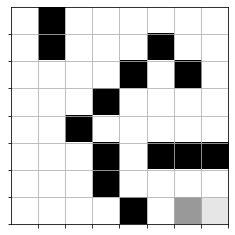

In [13]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

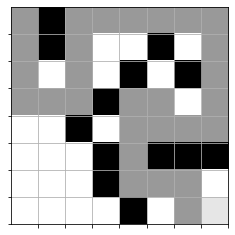

In [14]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.